### Lorentz System

$\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma (y - x), \\[6pt]$


$\frac{\mathrm{d}y}{\mathrm{d}t} = x (\rho - z) - y, \\[6pt]$


$\frac{\mathrm{d}z}{\mathrm{d}t} = x y - \beta z.$

$σ = 10$, $β = 8/3$ and $ρ = 28$

$x(0) = 0$, $y(0) = 1$, $z(0) = 1.05$

In [240]:
from typing import List, Tuple, Callable
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt
import autograd.numpy as np

In [257]:
XYZ_0 = np.array([0, 1, 1.05])
SBR = np.array([10, 8/3, 28])

def lorenz_derivatives(xyz, *, sbr=SBR) -> np.ndarry:
    """The Lorenz derivatives.
    
    Args:
        xyz : array-like, shape (3,)
        srb: array-like, shape (3,)

    Returns:
         xyz_dot : array, shape (3,)
            Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    s, b, r = sbr
    x, y, z = xyz
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return np.array([x_dot, y_dot, z_dot])

AttributeError: module 'autograd.numpy' has no attribute 'ndarry'

### Activation Functions

In [157]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def elu(z, alpha: float):
    return alpha * (np.exp(z) - 1) if z < 0 else z

### Trial Solution

In [261]:
'''
def trial_solution(
    input: np.array, nn_weights: list, initial_conditions: np.array) -> np.array:
    fp = forward_propogation(input, nn_weights)
    return np.array([initial_conditions[0] + input * fp[0], initial_conditions[1] + input * fp[1], initial_conditions[2] + input * fp[2]])
'''




### Loss Function

In [178]:
'''
def mse_loss_function(
    input, parameters: list, coefs: np.array, initial_conditions: np.array
):
    trial_sol = trial_solution(input, parameters, initial_conditions)
    prediction = right_hand_side(input, trial_sol, coefs)
    neural_network_gradient = elementwise_grad(trial_solution, 0)(
        input, parameters, initial_conditions
    )

    error_squared = (neural_network_gradient - prediction) ** 2
    error_squared = error_squared / np.size(error_squared)
    loss_sum_mean = np.sum(error_squared)

    return loss_sum_mean
'''



### Neural Network

![](NN.png "Neural Network")

### Optimizers

In [263]:
def init_nn_weights(t_size: int, hidden_sizes: np.array, output_size: int) -> List[np.array]:
    """Initializes the weights and biases of the neural network.

    Args:
        t_size: The size of the t layer
        hidden_sizes: The sizes of the hidden layers
        output_size: The size of the output layer

    Returns:
        A list of NumPy arrays of the weights and biases of the neural network.
    """
    nn_weights = [None] * (hidden_sizes.shape[0] + 1) # +1 for the output

    # hidden weights and biases
    nn_weights[0] = np.random.randn(hidden_sizes[0], t_size + 1) # +1 for the bias
    for i in range(1, hidden_sizes.shape[0]):
        nn_weights[i] = np.random.randn(hidden_sizes[i], hidden_sizes[i - 1] + 1) # +1 for the bias

    # output weights and biases
    nn_weights[-1] = np.random.randn(output_size, hidden_sizes[-1] + 1) # +1 for the bias

    return nn_weights

def forward_propogation(t: np.array, nn_weights: List[np.array], activation_fns: List[Callable]) -> np.array:
    """Makes a forward pass through the neural network.

    Args:
        t: The t vector
        nn_weights: The weights and biases of the neural network
        activation_fns: The activation fuctions for different layers 
     
    Returns:
        A NumPy array of the output of the neural network of dim(3, len(t)).
    """
    num_hidden_layers = len(nn_weights) - 1
    num_ts = t.size
    # (n,) -> (n, 1)
    t = t.reshape(-1, t.size)

    z = None
    a = t
    for i in range(num_hidden_layers):
        z = np.matmul(nn_weights[i], np.concatenate((np.ones((1, num_ts)), a), axis = 0))
        a = activation_fns[i](z)

    return z

def trial_solution(t: np.array, initial_conditions: np.array, nn_weights: List[np.array], activation_fns: List[Callable]) -> np.ndarray:
    """Calculates the trial solution of the Lorenz System.
    
    Args:
        t: The t vector t
        nn_weights: The nn_weights of the neural network
        initial_conditions: The initial conditions of the Lorentz System
        activation_fns: The activation fuctions for different layers
    
    Returns:
        A NumPy array of the trial solution of the Lorentz System with 
        dimension (3, len(t))
    """
    fp = forward_propogation(t, nn_weights, activation_fns)
    return initial_conditions + np.matmul(fp, t)

def elementwise_trial_solution(index, t: np.array, initial_conditions: np.array, nn_weights: List[np.array], activation_fns: List[Callable]):
    return trial_solution(t, initial_conditions, nn_weights, activation_fns)[index]

def trial_grad(t: np.array, initial_conditions: np.array, nn_weights: list, activation_fns: List[Callable]) -> np.array:
    """Calculates the gradient of the trial solution of the Lorentz System.
    
    Args:
        t: The t vector
        nn_weights: The nn_weights of the neural network
        initial_conditions: The initial conditions of the Lorentz System
    
    Returns:
        A NumPy array of the gradient of the trial solution of the Lorentz System with 
        dimension (3, len(t))
    """
    return np.array(
        [elementwise_grad(elementwise_trial_solution, 1)(0, t, initial_conditions, nn_weights, activation_fns), 
         elementwise_grad(elementwise_trial_solution, 1)(1, t, initial_conditions, nn_weights, activation_fns), 
         elementwise_grad(elementwise_trial_solution, 1)(2, t, initial_conditions, nn_weights, activation_fns)])

def mse_loss_function(t: np.array, coefs: np.array, initial_conditions: np.array, nn_weights: List[np.array], activation_fns: List[Callable]) -> float:
    trial_sol = trial_solution(t, nn_weights, initial_conditions)
    
    grad_star = lorenz_derivatives(trial_sol, coefs)
    grad = trial_grad(t, initial_conditions, nn_weights, activation_fns)
    error = grad_star - grad
    
    return np.linalg.norm(error, 'fro') / np.sqrt(np.size(error))

def solve_lorenz(
    t: np.array,
    coefs: np.array,
    initial_conditions: np.array,
    nn_weights: list,
    activation_fns: List[Callable],
    num_iter: int,
    learn_rate: float,
):
    loss_grad_function = grad(mse_loss_function, 3)

    for i in range(num_iter):
        print("iteration: ", i)
        print(mse_loss_function(t, coefs, initial_conditions, nn_weights, activation_fns))
        loss_grad = loss_grad_function(t, coefs, initial_conditions, nn_weights, activation_fns)
        
        for j in range(len(nn_weights)):
            nn_weights[j] = nn_weights[j] - learn_rate * loss_grad[j]

    return nn_weights

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' on line 80 (2150899817.py, line 82)

In [163]:
def adam(input, nn_weights, coefs, initial_conditions, grad, num_iters=50000,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    m = [np.zeros_like(nn_weights[i]) for i in range(len(nn_weights))]
    v = [np.zeros_like(nn_weights[i]) for i in range(len(nn_weights))]
    mhat = [None] * len(nn_weights)
    vhat = [None] * len(nn_weights)
    for i in range(num_iters):
        g = grad(input, nn_weights, coefs, initial_conditions)
        print("iteration: ", i)
        print(MSE_loss_function(input, nn_weights, coefs, initial_conditions))

        if MSE_loss_function(input, nn_weights, coefs, initial_conditions) < 0.15:
            return nn_weights
        
        for j in range(len(nn_weights)):
            m[j] = (1 - b1) * g[j]      + b1 * m[j]  # First  moment estimate.
            v[j] = (1 - b2) * (g[j]**2) + b2 * v[j]  # Second moment estimate.
            mhat[j] = m[j] / (1 - b1**(i + 1))    # Bias correction.
            vhat[j] = v[j] / (1 - b2**(i + 1)) 
            nn_weights[j] = nn_weights[j] - step_size * mhat[j]/(np.sqrt(vhat[j]) + eps)
    
    return nn_weights

### Training

In [250]:
def train_lorenz(initial_conditions, sbr):
    t = np.arange(0, 10, 0.01)
    nn_weights = init_nn_weights(1, np.array([100, 100, 100]), 3)

    loss_grad_function = grad(mse_loss_function, 1)
    nn_weights = solve_lorenz(t, nn_weights, sbr, initial_conditions, num_iter=100000, learn_rate=0.00001)

    res = np.array(
        [trial_solution_x(t, nn_weights, initial_conditions), 
         trial_solution_y(t, nn_weights, initial_conditions), 
         trial_solution_z(t, nn_weights, initial_conditions)])
train_lorenz(XYZ_0, SBR)

iteration:  0
1715.5256527991755
iteration:  1
1609.1392540075017
iteration:  2
1509.8675897914034
iteration:  3
1417.4023779878114
iteration:  4
1331.3621732435367
iteration:  5
1251.3148928626588
iteration:  6
1176.8046531580112
iteration:  7
1107.3778543250692
iteration:  8
1042.6049247395388
iteration:  9
982.096021239679
iteration:  10
925.5105907585133
iteration:  11
872.5616785574797
iteration:  12
823.0162150515879
iteration:  13
776.6924163166226
iteration:  14
733.4551168198932
iteration:  15
693.2094914382617
iteration:  16
655.8933292896756
iteration:  17
621.4678624738024
iteration:  18
589.9071727528303
iteration:  19
561.1864215937381
iteration:  20
535.2695564262492
iteration:  21
512.0976480366348
iteration:  22
491.5794285691076
iteration:  23
473.5856869882453
iteration:  24
457.94875071072306
iteration:  25
444.46734493611376
iteration:  26
432.9159472083484
iteration:  27
423.05678401554894
iteration:  28
414.6522202801933
iteration:  29
407.4755657432789
iteration

KeyboardInterrupt: 

### Evaluating Results

In [224]:
def plot(nn_weights, initial_conditions, scale=1, dt=0.01):
   t = np.arange(0, 10, dt)
   res = trial_solution(t, nn_weights, initial_conditions) * scale
   fig = plt.figure(figsize=(10, 10))
   ax = fig.add_subplot(projection="3d")
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.plot(res[0], res[1], res[2], lw=1)

   xyzs, dxyz_dt = simulate_pde(t, initial_conditions, derivative=lorenz_derivative)
   #ax.plot(xyzs[:, 0], xyzs[:, 1], xyzs[:, 2], lw=1)

def simulate_pde(t, initial_conditions, derivative) -> Tuple[np.ndarray, np.ndarray]:
   """Simulate the PDE over the time interval [0, dt * num_steps].

   Args:
      dt: The time step
      initial_conditions: The initial conditions as a NumPy array of length 3
      num_steps: The number of time steps to calculate
   
   Returns:
      A tuple of two NumPy arrays: the x, y, and z values, and the derivatives.
   """
   dxyz_dt = np.empty((len(t), 3))
   xyzs = np.empty((len(t), 3))
   xyzs[0] = initial_conditions

   for i in range(len(t) - 1):
      dt = t[i + 1] - t[i]
      xyzs[i + 1] = xyzs[i] + derivative(xyzs[i]) * dt
      dxyz_dt[i] = derivative(xyzs[i])
   
   return xyzs, dxyz_dt

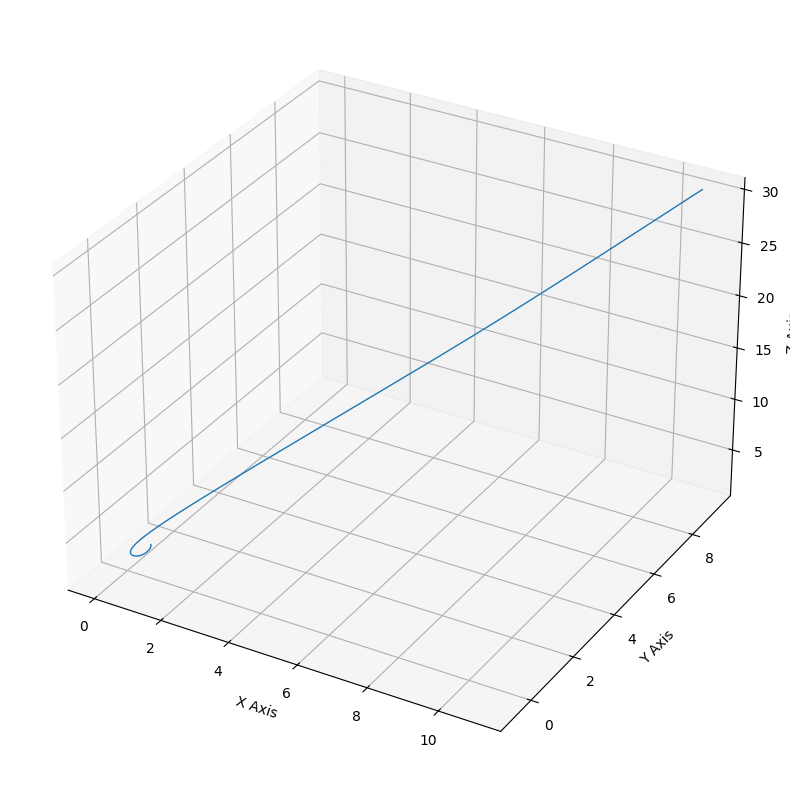

In [227]:
plot(nn_weights, initial_conditions)

In [210]:
xyzs, dxyz_dt = simulate_pde(t, initial_conditions, derivative=lorenz_derivative)
print("xyz: ", xyzs)
print("dxyz: ", dxyz_dt)

xyz:  [[  0.           1.           1.05      ]
 [  0.1          0.99         1.0219965 ]
 [  0.189        1.007078     0.99572985]
 [  0.2708078    1.04804529   0.97107712]
 [  0.34853155   1.11076127   0.94801668]
 [  0.42475452   1.19393836   0.92660443]
 [  0.50167291   1.29699444   0.90696319]
 [  0.58120506   1.41994293   0.88928115]
 [  0.66507885   1.56331237   0.87381681]
 [  0.7549022    1.72808975   0.86090937]
 [  0.85222095   1.91568244   0.85099431]
 [  0.9585671    2.12789513   0.84462414]
 [  1.07549991   2.36691868   0.84249531]
 [  1.20464178   2.63532843   0.84548217]
 [  1.34771045   2.93608981   0.85467943]
 [  1.50654838   3.27256924   0.87145512]
 [  1.68315047   3.6485482    0.89751625]
 [  1.87969024   4.0682383    0.93499005]
 [  2.09854505   4.53629427   0.98652414]
 [  2.34231997   5.05782129   1.05540972]
 [  2.6138701    5.63837159   1.1457323 ]
 [  2.91632025   6.28392355   1.26255533]
 [  3.25308058   7.00083383   1.41214231]
 [  3.62785591   7.79574993 